In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(tidyverse)) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
suppressPackageStartupMessages(library(RColorBrewer)) # for a colourful plot
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(clusterProfiler)) # for PEA analysis
suppressPackageStartupMessages(library('org.Hs.eg.db'))
suppressPackageStartupMessages(library(DOSE))
suppressPackageStartupMessages(library(enrichplot)) # for visualisations
suppressPackageStartupMessages(library(ggupset)) # for visualisations
suppressPackageStartupMessages(library(ggrepel))

Warning message:
“package ‘stringr’ was built under R version 4.3.2”


## Differential expression analysis of Olink at Time point 2
### Comparing protein expression at between the 3 groups with prediabetic group as control
#### Identify proteins at T2 which are predictive of the outcome 

In [2]:
d = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/t2_Olink_QCed.csv')
protein_info = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv')
sample_info = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/sample-info.csv')
protein_info = subset(protein_info, select = -c(MissingFreq, Panel, Panel_Lot_Nr, Normalization, ExploreVersion))
d2 <- inner_join(d, protein_info, by = "OlinkID")
head(d2)
# For use later
assay.ids = unique(d2[,.(OlinkID, UniProt, Assay)])

SampleID,OlinkID,LOD,NPX,QC_Warning,Assay_Warning,belowLOD,status,UniProt,Assay
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
Sample_283,OID20049,-0.3111,-0.0446,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_709,OID20049,-0.3111,1.0418,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_1372,OID20049,-0.3111,1.4322,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_1380,OID20049,-0.3111,-0.4819,PASS,PASS,TRUE,belowLOD,P16860,NPPB
Sample_1070,OID20049,-0.3111,3.3083,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_266,OID20049,-0.3111,1.0342,PASS,PASS,FALSE,ok,P16860,NPPB


In [3]:
options(width=300)
covar = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/T2_final_covariates.csv')
covar$SubjectID <- gsub("SubjectID_", "", covar$SubjectID)
covar[,`:=`(
    Gender=as.factor(Gender),
    Site=as.factor(Site))]
#adding case-control information
healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/3_healthy_pQTLs/subject_ids.txt")
prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/subject_ids.txt")
diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/4_diabetic_pQTLs/subject_ids.txt")
#healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/remission_clean.txt")
#prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/prediabetes_clean.txt")
#diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/diabetic_clean.txt")

# covar[grepl('FB', SampleID), sample.type:='control']
summary(covar)

   SampleID          SubjectID              Age             Age2      Gender     MeanNPX              Site      storage_time  
 Length:458         Length:458         Min.   :27.00   Min.   : 729   m:211   Min.   :-0.51080   TUE    :137   Min.   :0.670  
 Class :character   Class :character   1st Qu.:54.00   1st Qu.:2916   w:247   1st Qu.:-0.11218   DRE    :125   1st Qu.:1.490  
 Mode  :character   Mode  :character   Median :61.00   Median :3721           Median : 0.01579   Charite: 40   Median :2.260  
                                       Mean   :60.22   Mean   :3711           Mean   : 0.03812   TUM    : 36   Mean   :2.513  
                                       3rd Qu.:67.00   3rd Qu.:4489           3rd Qu.: 0.16522   LEI    : 35   3rd Qu.:3.667  
                                       Max.   :80.00   Max.   :6400           Max.   : 1.05790   LMU    : 27   Max.   :5.160  
                                                                                                 (Other): 58   

In [4]:
healthy$status <- rep("healthy", length(healthy$V1))
prediabetes$status <- rep("prediabetes", length(prediabetes$V1))
diabetes$status <- rep("diabetes", length(diabetes$V1))
t2d_status <- rbind(healthy, prediabetes, diabetes)
colnames(t2d_status)[colnames(t2d_status) == "V1"] <- "SubjectID"

In [5]:
covar$SubjectID = as.numeric(covar$SubjectID)
t2d_status$SubjectID = as.numeric(t2d_status$SubjectID)
covar_2 <- inner_join(covar, t2d_status, by = "SubjectID")
head(covar_2)

SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>
Sample_1362,70047,63,3969,m,0.02286598,LEI,1.71,diabetes
Sample_283,3266,66,4356,w,-0.11514891,TUE,4.21,healthy
Sample_709,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes
Sample_1010,40254,67,4489,w,0.12119739,Charite,1.94,prediabetes
Sample_324,263,67,4489,w,-0.05120503,TUE,3.43,healthy
Sample_728,20062,41,1681,m,0.20118297,DRE,3.78,diabetes


In [6]:
covar_2$status <- factor(covar_2$status, levels = c('prediabetes', 'diabetes', 'healthy'))

In [7]:
# Exclude the 3 bimodal distribution assays
bimodal.assays = assay.ids[Assay %in% c('TDGF1', 'PNLIPRP2', 'FOLR3'), OlinkID]
d3 <- d2[d2$Assay != "TDGF1"]
d3 <- d3[d3$Assay != "PNLIPRP2"]
d3 <- d3[d3$Assay != "FOLR3"]

#### Seperating diabetes and healthy to be compared against prediabetes

#### Healthy vs. Prediabetes

In [8]:
sample_subject_ids = subset(covar_2, select = -c(Age, Age2, Gender, MeanNPX, Site, storage_time))
d3.1 = inner_join(d3, sample_subject_ids, by = "SampleID")
d3.1 = d3.1[!d3.1$status.y == "diabetes"]
d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID))
#d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID, Group, rando))
covar_3 <- covar_2[!covar_2$status == "diabetes"]
covar_3$status <- factor(covar_3$status, levels = c('prediabetes', 'healthy'))
# covar_3$Group <- factor(covar_3$Group, levels = c('Hochrisiko', 'Niedrigrisiko'))
# covar_3$rando <- factor(covar_3$rando, levels = c('Lifestyle Intervention', 'No Lifestyle Intervention', 'Intensified Lifestyle Intervention'))
head(d3.1)
head(covar_3)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_283,OID20049,-0.0446
Sample_709,OID20049,1.0418
Sample_1372,OID20049,1.4322
Sample_1380,OID20049,-0.4819
Sample_1070,OID20049,3.3083
Sample_266,OID20049,1.0342


SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>
Sample_283,3266,66,4356,w,-0.11514891,TUE,4.21,healthy
Sample_709,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes
Sample_1010,40254,67,4489,w,0.12119739,Charite,1.94,prediabetes
Sample_324,263,67,4489,w,-0.05120503,TUE,3.43,healthy
Sample_1294,60355,60,3600,w,-0.08977184,TUM,2.07,prediabetes
Sample_1372,70078,60,3600,m,0.41756693,LEI,1.34,prediabetes


In [9]:
wide = reshape(d3.1, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide) = sub('NPX.', '', colnames(wide))
wide = as.matrix(wide)
rownames(wide) = wide[,1]
wide = wide[,2:ncol(wide)]
class(wide) = "numeric"
cat('Number of assays included in analysis:', length(unique(d3.1[,OlinkID])), '\n')

Number of assays included in analysis: 2523 


In [10]:
in_prot = wide
in_prot = t(in_prot)

in_pheno = covar_3
in_pheno = as.data.frame(in_pheno)
rownames(in_pheno) = in_pheno[,1]

In [11]:
table(merge(unique(d3.1[,.(SampleID)]), covar_3[,.(SampleID, status)])[,status])


prediabetes     healthy 
        321          49 

In [12]:
keep_samples = intersect(colnames(in_prot), rownames(in_pheno))
curr_prot = in_prot[,keep_samples]
curr_pheno = in_pheno[keep_samples,]

In [13]:
print(paste0("protein matrices and phenotype info in same sample order: ", 
   identical(colnames(curr_prot), rownames(curr_pheno))))
print(paste0("# samples being tested: ", nrow(curr_pheno)))

[1] "protein matrices and phenotype info in same sample order: TRUE"
[1] "# samples being tested: 370"


In [14]:
options(repr.matrix.max.rows = 5)
design = model.matrix(as.formula("~ status + Age + Age2 + Gender + MeanNPX + Site + storage_time"), 
                                       data = curr_pheno)
design

,(Intercept),statushealthy,Age,Age2,Genderw,MeanNPX,SiteDDZ,SiteDIF,SiteDIF-Charite,SiteDRE,SiteLEI,SiteLMU,SiteTUE,SiteTUM,SiteUKH,storage_time
Sample_283,1,1,66,4356,1,-0.11514891,0,0,0,0,0,0,1,0,0,4.21
Sample_709,1,0,62,3844,0,0.09212044,0,0,0,1,0,0,0,0,0,3.93
Sample_1372,1,0,60,3600,0,0.41756693,0,0,0,0,1,0,0,0,0,1.34
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sample_1023,1,0,68,4624,0,-0.11260820,0,0,0,0,0,0,0,0,0,1.15
Sample_826,1,0,55,3025,0,0.03397639,0,0,0,1,0,0,0,0,0,1.22


In [15]:
fit_here = lmFit(curr_prot, design)
# https://stat.ethz.ch/pipermail/bioconductor/2004-September/006132.html
# --> ebayes explanation
bayes = eBayes(fit_here)

In [16]:
ls(fit_here)
ls(bayes)

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.residual"      "method"           "pivot"            "rank"             "sigma"            "stdev.unscaled"

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.prior"         "df.residual"      "df.total"         "F"                "F.p.value"        "lods"             "method"           "p.value"          "pivot"            "proportion"       "rank"            
[16] "s2.post"          "s2.prior"         "sigma"            "stdev.unscaled"   "t"                "var.prior"

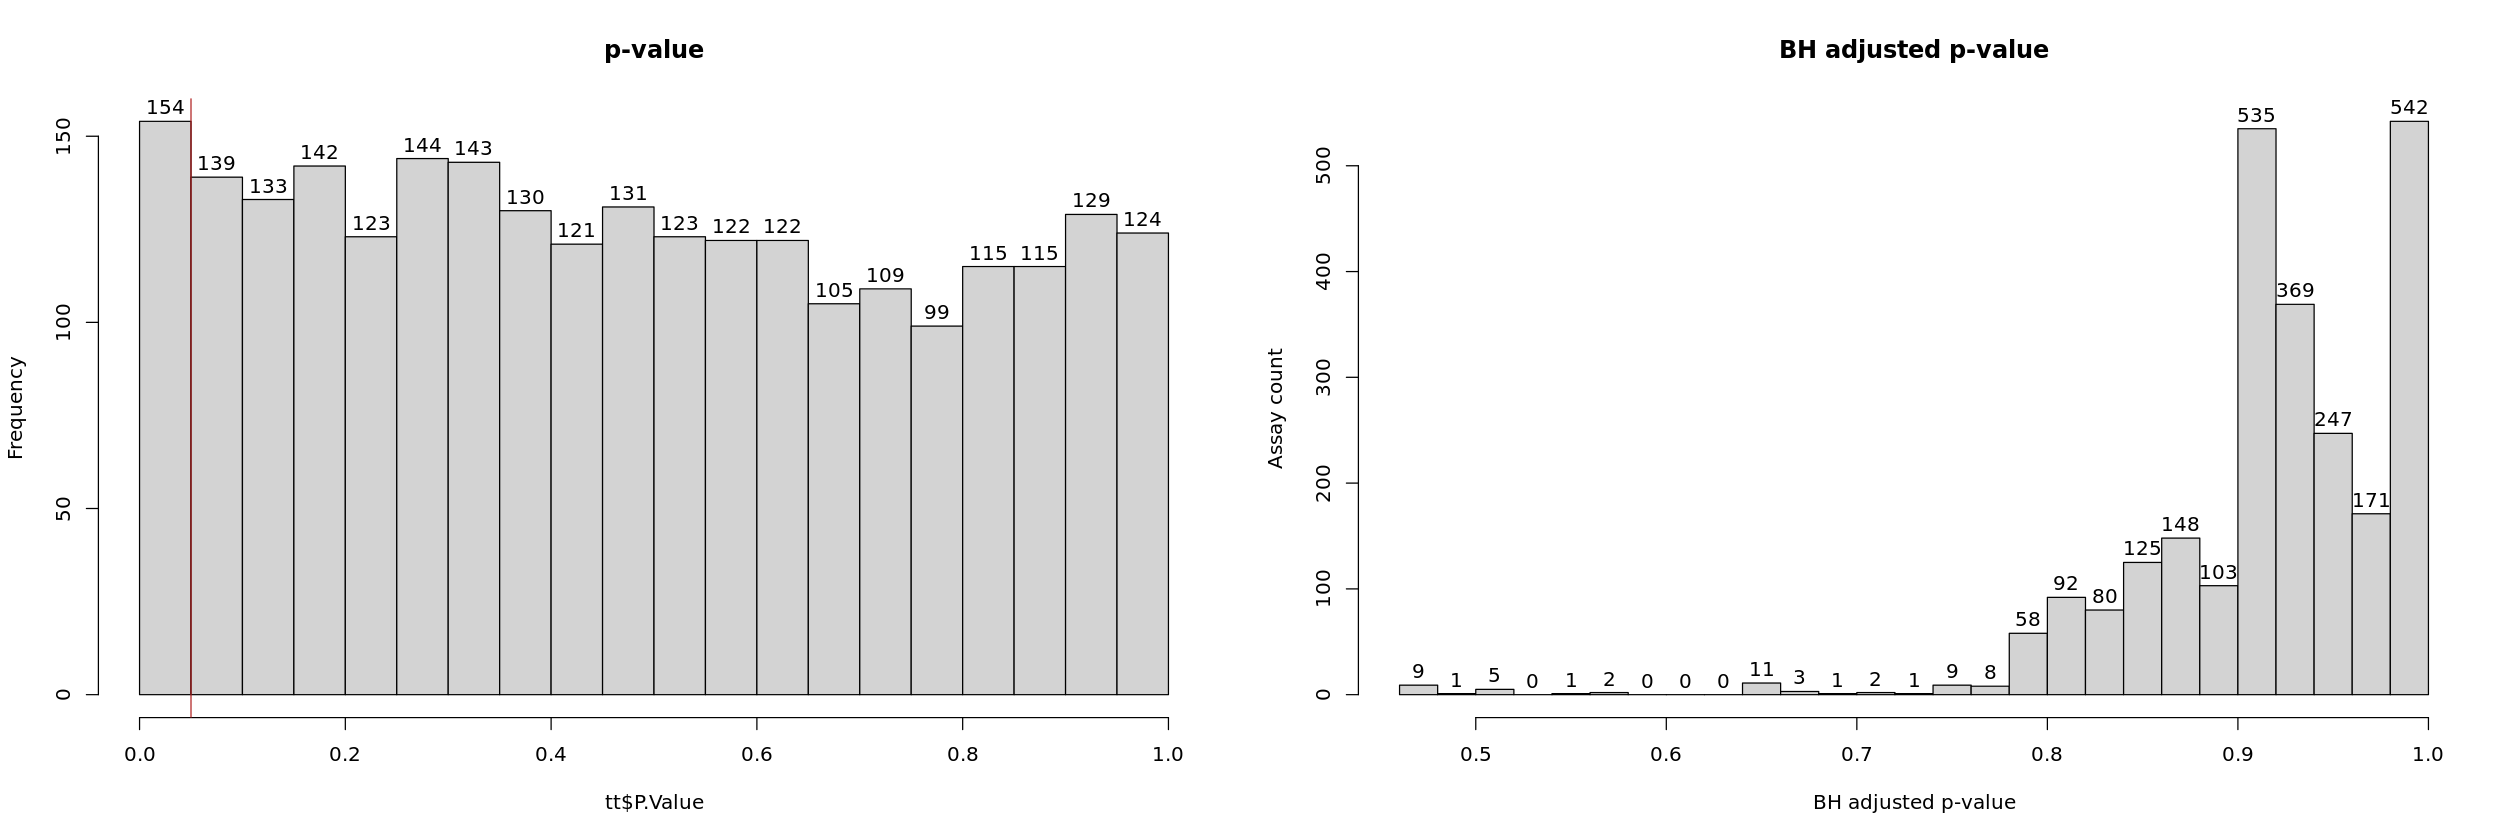

In [17]:
tt = topTable(bayes, coef = "statushealthy", n = Inf, adjust.method="BH")
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

In [18]:
options(repr.matrix.max.rows = 10)
tt
dim(tt)
cat(paste0(nrow(tt[tt$adj.P.Val<0.05,]), ' out of 2536 assays with FDR<0.05'))

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OID30574,-0.2203124,-0.17095270,-3.670601,0.0002789276,0.4769986,-0.2959330
OID20665,0.2289532,-0.04760351,3.469049,0.0005861662,0.4769986,-0.8201998
OID20966,0.2048438,0.03535297,3.321580,0.0009875907,0.4769986,-1.1865424
OID20763,-0.2275084,0.01401676,-3.308608,0.0010330552,0.4769986,-1.2180646
OID20396,0.1395942,0.02491568,3.262672,0.0012101567,0.4769986,-1.3287696
⋮,⋮,⋮,⋮,⋮,⋮,⋮
OID31378,1.878239e-04,0.087732432,0.0015644720,0.9987526,0.9993084,-5.306695
OID30269,9.358654e-05,-0.021636486,0.0014683791,0.9988292,0.9993084,-5.306695
OID21298,-7.646475e-05,0.005894054,-0.0011036030,0.9991201,0.9993084,-5.306695


[1] 2523    6

0 out of 2536 assays with FDR<0.05

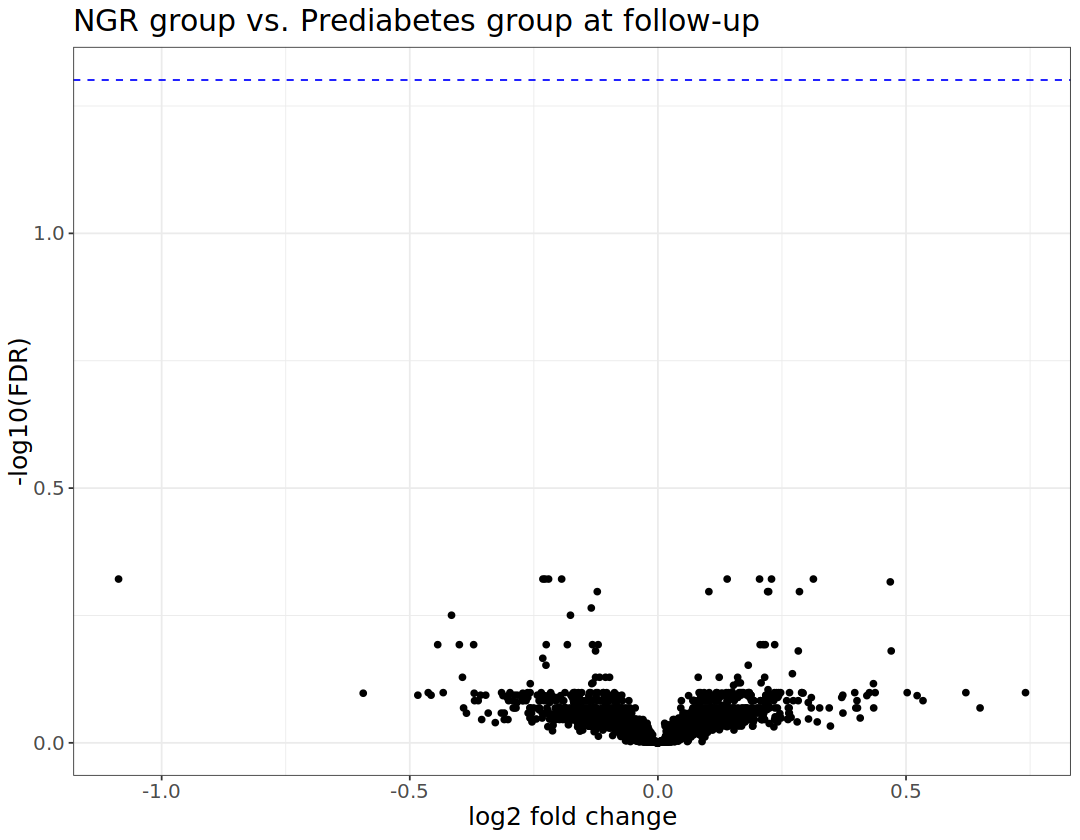

In [19]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'
p1 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = "log2 fold change",
        y = "-log10(FDR)",
        title = "NGR group vs. Prediabetes group at follow-up"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=15))
print(p1)
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/plots/follow-up_healthy_vs_prediabetes.pdf", plot = p1, width = 6, height = 5, units = "in")

#### Diabetes vs. Prediabetes

In [21]:
sample_subject_ids = subset(covar_2, select = -c(Age, Age2, Gender, MeanNPX, Site, storage_time))
d3.1 = inner_join(d3, sample_subject_ids, by = "SampleID")
d3.1 = d3.1[!d3.1$status.y == "healthy"]
d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID))
#d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID, Group, rando))
covar_3 <- covar_2[!covar_2$status == "healthy"]
covar_3$status <- factor(covar_3$status, levels = c('prediabetes', 'diabetes'))
# covar_3$Group <- factor(covar_3$Group, levels = c('Hochrisiko', 'Niedrigrisiko'))
# covar_3$rando <- factor(covar_3$rando, levels = c('Lifestyle Intervention', 'No Lifestyle Intervention', 'Intensified Lifestyle Intervention'))
head(d3.1)
head(covar_3)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_709,OID20049,1.0418
Sample_1372,OID20049,1.4322
Sample_1070,OID20049,3.3083
Sample_266,OID20049,1.0342
Sample_1010,OID20049,2.9004
Sample_287,OID20049,-0.2581


SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>
Sample_1362,70047,63,3969,m,0.02286598,LEI,1.71,diabetes
Sample_709,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes
Sample_1010,40254,67,4489,w,0.12119739,Charite,1.94,prediabetes
Sample_728,20062,41,1681,m,0.20118297,DRE,3.78,diabetes
Sample_1294,60355,60,3600,w,-0.08977184,TUM,2.07,prediabetes
Sample_1372,70078,60,3600,m,0.41756693,LEI,1.34,prediabetes


In [22]:
wide = reshape(d3.1, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide) = sub('NPX.', '', colnames(wide))
wide = as.matrix(wide)
rownames(wide) = wide[,1]
wide = wide[,2:ncol(wide)]
class(wide) = "numeric"
cat('Number of assays included in analysis:', length(unique(d3.1[,OlinkID])), '\n')

Number of assays included in analysis: 2523 


In [23]:
in_prot = wide
in_prot = t(in_prot)

in_pheno = covar_3
in_pheno = as.data.frame(in_pheno)
rownames(in_pheno) = in_pheno[,1]

In [24]:
table(merge(unique(d3.1[,.(SampleID)]), covar_3[,.(SampleID, status)])[,status])


prediabetes    diabetes 
        321          88 

In [25]:
keep_samples = intersect(colnames(in_prot), rownames(in_pheno))
curr_prot = in_prot[,keep_samples]
curr_pheno = in_pheno[keep_samples,]

In [26]:
print(paste0("protein matrices and phenotype info in same sample order: ", 
   identical(colnames(curr_prot), rownames(curr_pheno))))
print(paste0("# samples being tested: ", nrow(curr_pheno)))

[1] "protein matrices and phenotype info in same sample order: TRUE"
[1] "# samples being tested: 409"


In [27]:
options(repr.matrix.max.rows = 5)
# design = model.matrix(as.formula("~ status + Age + Age2 + Gender + MeanNPX + Site + storage_time + Group + rando"), 
#                                        data = curr_pheno)
design = model.matrix(as.formula("~ status + Age + Age2 + Gender + MeanNPX + Site + storage_time"), 
                                       data = curr_pheno)
#design2 = model.matrix(as.formula("~ status + Age + Age2 + Gender + Site + storage_time"), 
                                      # data = curr_pheno)

In [28]:
fit_here = lmFit(curr_prot, design)
# https://stat.ethz.ch/pipermail/bioconductor/2004-September/006132.html
# --> ebayes explanation
bayes = eBayes(fit_here)

# #for design2 (without adjusting for mean NPX)
# fit_here2 = lmFit(curr_prot, design2)
# # https://stat.ethz.ch/pipermail/bioconductor/2004-September/006132.html
# # --> ebayes explanation
# bayes2 = eBayes(fit_here2)

### Adjusted for Mean NPX

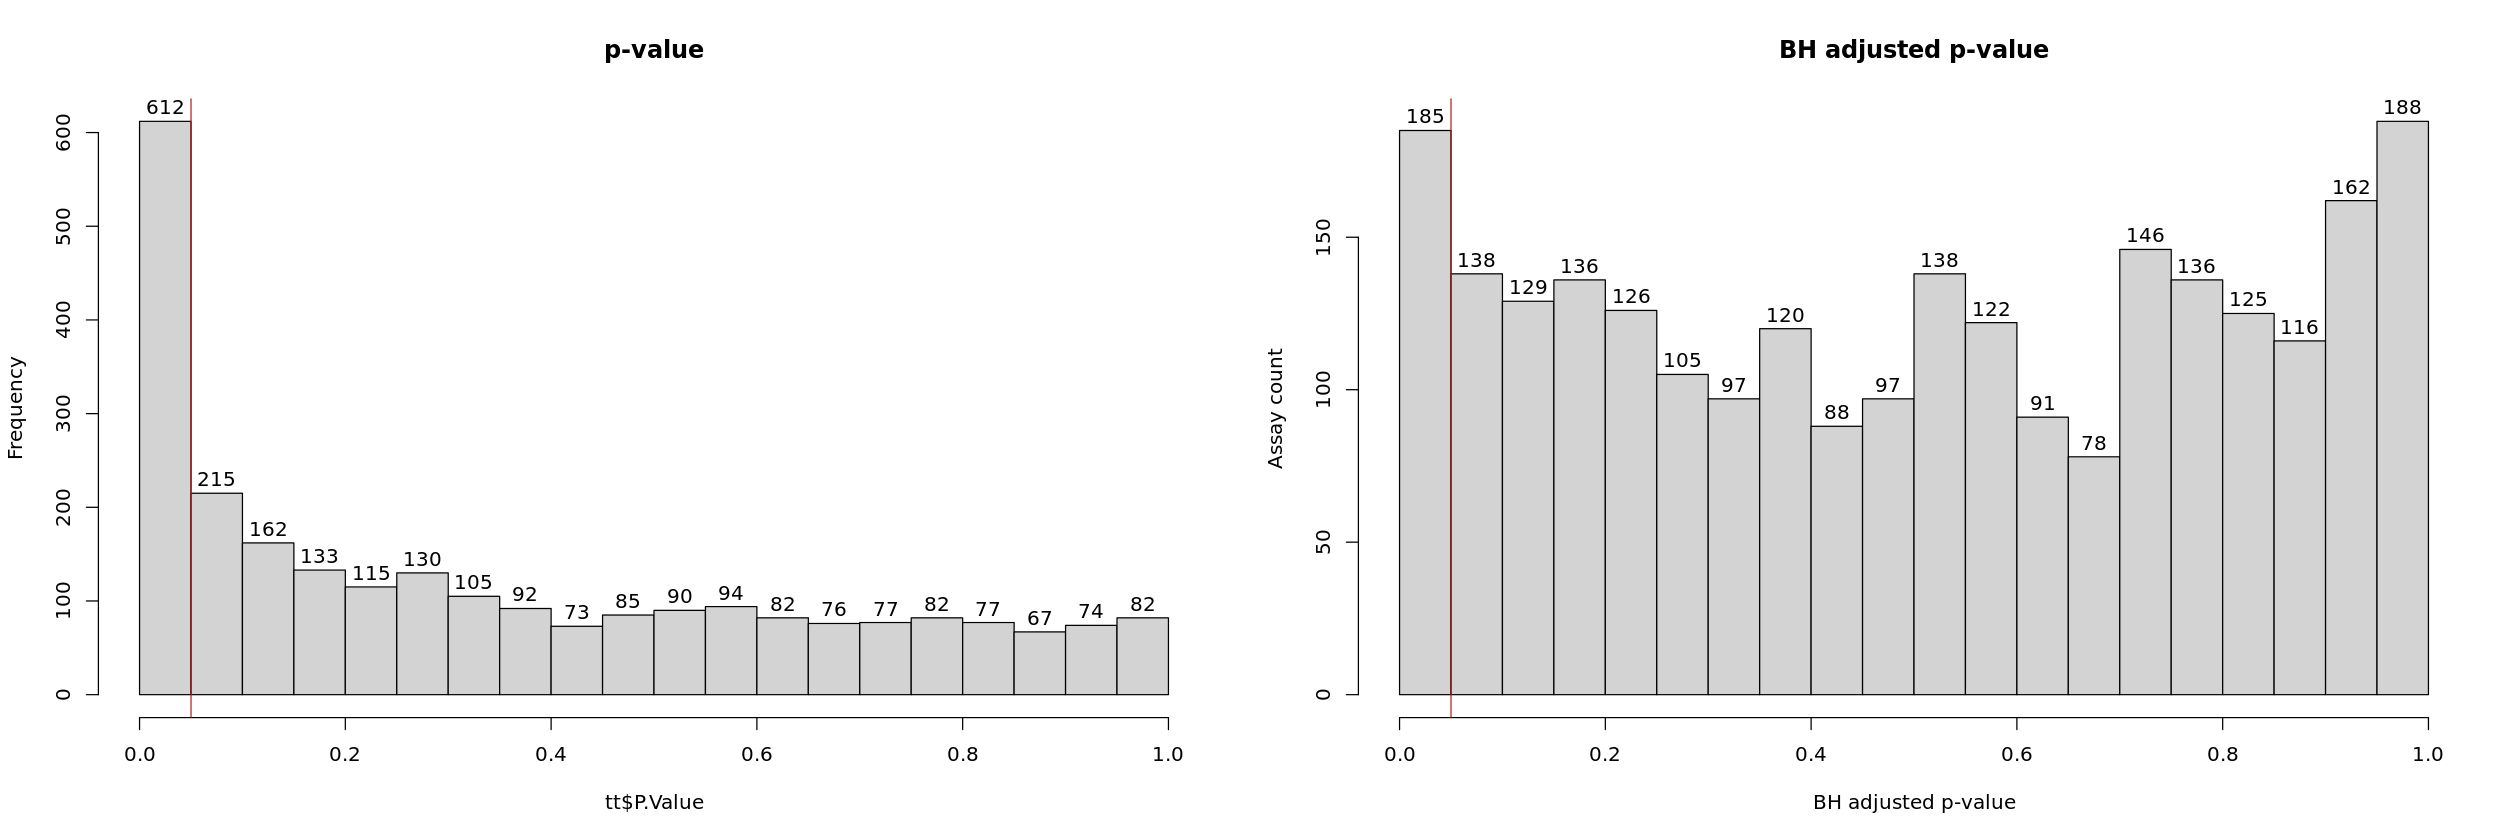

In [29]:
tt = topTable(bayes, coef = "statusdiabetes", n = Inf, adjust.method="BH")
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

In [30]:
tt_fdr005$OlinkID <- rownames(tt_fdr005)
rownames(tt_fdr005) <- NULL   # remove row names
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv", header = T, sep = ",")

tt_fdr005 <- merge(tt_fdr005, 
                   prot_ids[, c("OlinkID", "Assay")], 
                   by = "OlinkID", 
                   all.x = TRUE)

fwrite(tt_fdr005, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/differentially_expressed_proteins_prediabetes-vs-T2D.txt")

In [31]:
# Get the downregulated proteins by absolute logFC
downregulated <- tt_fdr005[tt_fdr005$logFC < 0, ]  # filter for negative logFC
#upregulated proteins
up <- tt_fdr005[tt_fdr005$logFC > 0, ]  # filter for negative logFC

In [32]:
#writing files to be used in delta-analysis
tmp <- inner_join(up, prot_ids, by = "OlinkID")
fwrite(tmp, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/UP_FDR-corrected_with_all_info.txt", col.names = T, row.names = F)
tmp <- inner_join(downregulated, prot_ids, by = "OlinkID")
fwrite(tmp, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/DOWN_FDR-corrected_with_all_info.txt", col.names = T, row.names = F)

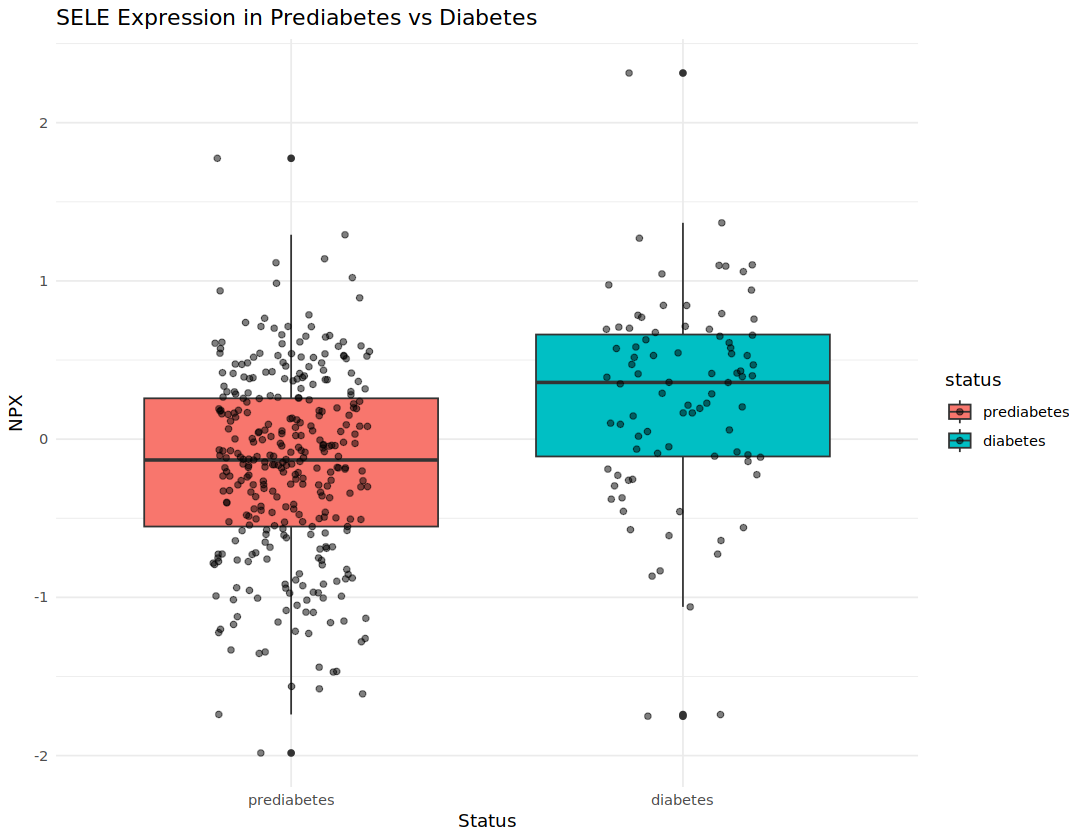

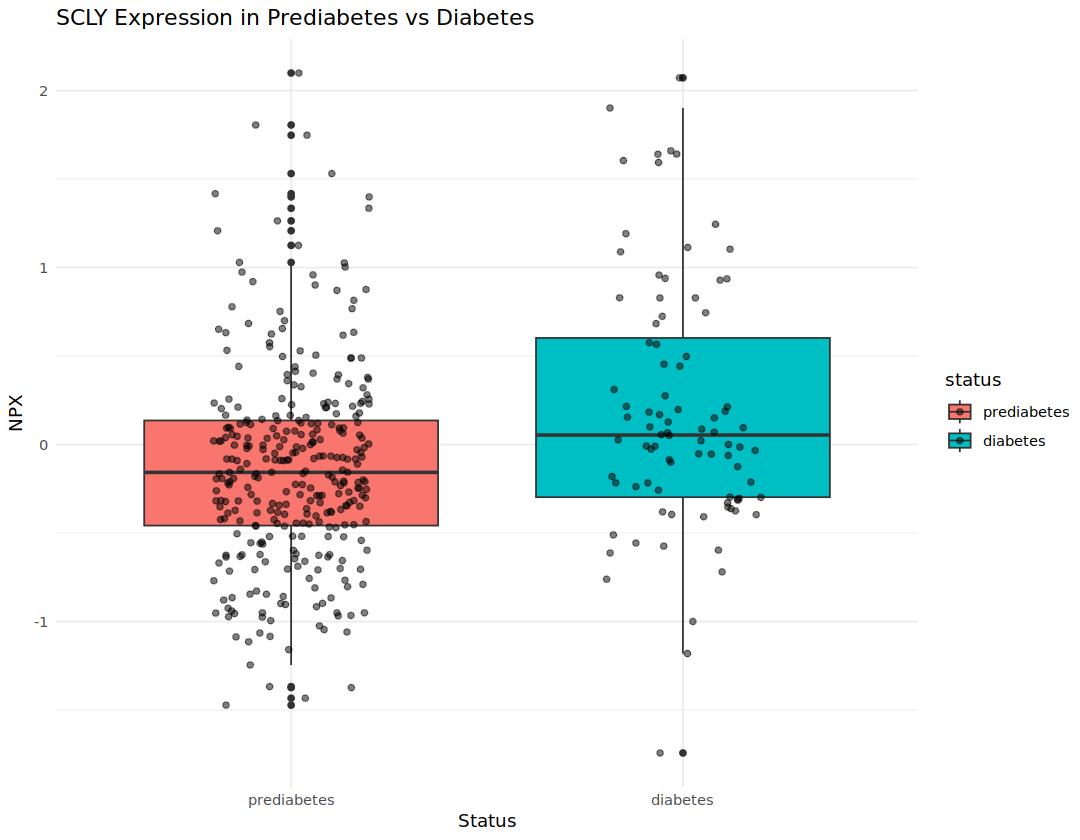

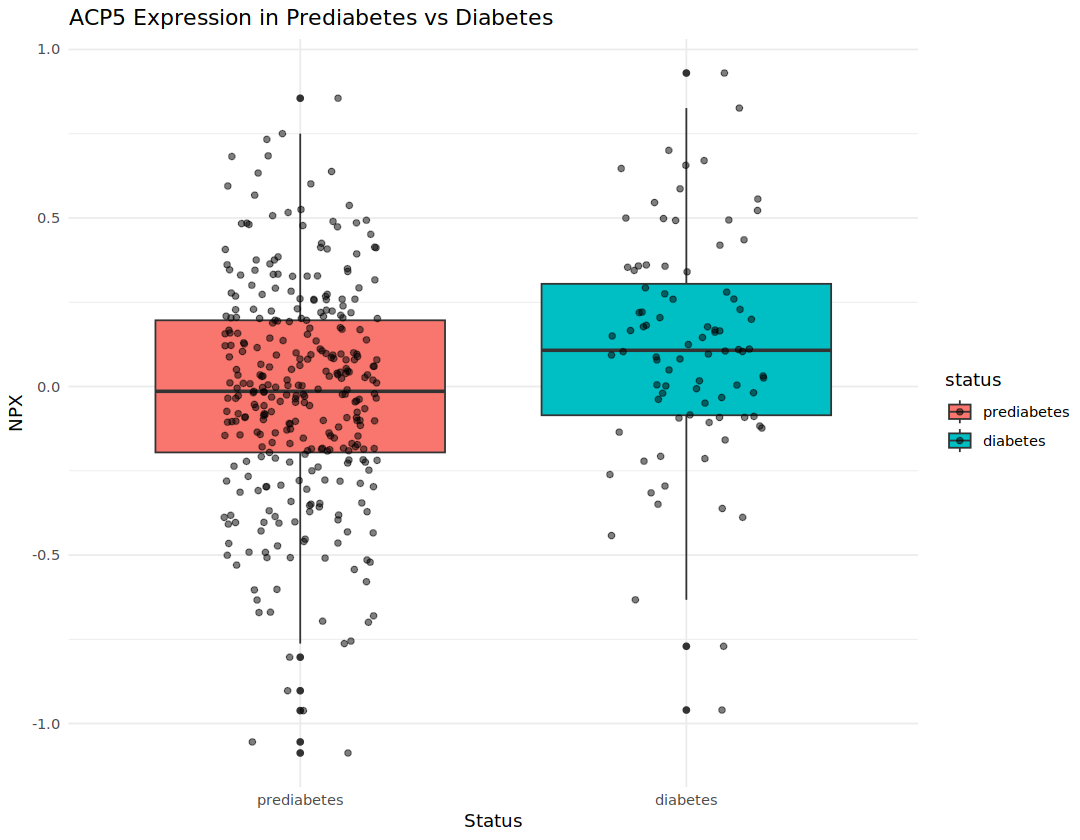

In [33]:
options(repr.plot.width=9, repr.plot.height=7)

#visualizing the difference between the groups for upregulated and downregulated proteins 
# Convert matrices to data frames
protein_df <- as.data.frame(curr_prot)
status_df <- as.data.frame(curr_pheno)

# Add sample IDs as a column if they are row names
protein_df$Protein <- rownames(protein_df)
status_df$SampleID <- rownames(status_df)

# Melt protein_df to long format if it contains multiple proteins
protein_long <- melt(protein_df, id.vars = "Protein", variable.name = "SampleID", value.name = "Expression")

# Merge with status information
merged_df <- left_join(protein_long, status_df, by = "SampleID")

# Filter for a specific protein (change "ProteinX" to your protein of interest)
selected_protein <- merged_df %>%
  filter(Protein == "OID20290" & status %in% c("prediabetes", "diabetes"))
selected_protein2 <- merged_df %>%
  filter(Protein == "OID21425" & status %in% c("prediabetes", "diabetes"))
selected_protein3 <- merged_df %>%
  filter(Protein == "OID20314" & status %in% c("prediabetes", "diabetes"))

# Box plot comparing expression between prediabetics and diabetics
ggplot(selected_protein, aes(x = status, y = Expression, fill = status)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +  # Adds scatter points for better visualization
  theme_minimal() +
  labs(title = "SELE Expression in Prediabetes vs Diabetes",
       x = "Status",
       y = "NPX")
         
ggplot(selected_protein2, aes(x = status, y = Expression, fill = status)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +  # Adds scatter points for better visualization
  theme_minimal() +
  labs(title = "SCLY Expression in Prediabetes vs Diabetes",
       x = "Status",
       y = "NPX")

ggplot(selected_protein3, aes(x = status, y = Expression, fill = status)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +  # Adds scatter points for better visualization
  theme_minimal() +
  labs(title = "ACP5 Expression in Prediabetes vs Diabetes",
       x = "Status",
       y = "NPX")

In [33]:
cat(paste0(nrow(tt[tt$adj.P.Val<0.05,]), ' out of 2523 assays with FDR<0.05'))

185 out of 2523 assays with FDR<0.05

Saving 7 x 7 in image


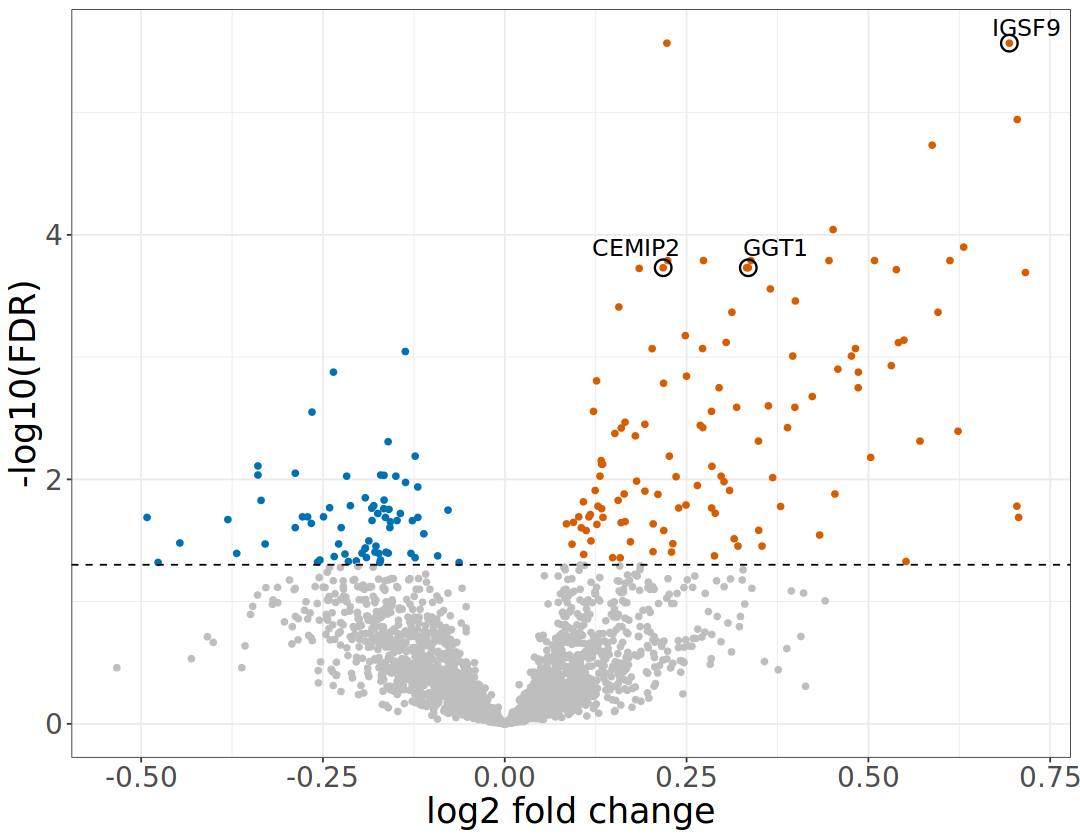

In [34]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv", header = T, sep = ",")
#with colours
tt2$OlinkID <- rownames(tt2)
tt2 <- inner_join(tt2, prot_ids, by = "OlinkID")
ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
    geom_point(aes(color = case_when(
        adj.P.Val < 0.05 & logFC > 0 ~ "#D55E00",
        adj.P.Val < 0.05 & logFC < 0 ~ "#0072B2",
        TRUE ~ "grey"
    )), show.legend = FALSE) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "black") +
    xlab("log2 fold change") +
    ylab("-log10(FDR)") +
    theme_bw() +
    scale_color_identity() +  # Use actual color values
    theme(text = element_text(size = 21)) +
  # Add labels for selected IDs
  geom_text_repel(
    data = subset(tt2, Assay %in% c("IGSF9", "CEMIP2", "GGT1")),
    aes(label = Assay),
    size = 5,
    box.padding = 0.4,
    point.padding = 0.5,
    max.overlaps = Inf
  ) +
# Add circle around those points
  geom_point(
    data = subset(tt2, Assay %in% c("IGSF9", "CEMIP2", "GGT1")),
    shape = 21, color = "black", fill = NA, size = 4, stroke = 1
  )
p <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
    geom_point(aes(color = case_when(
        adj.P.Val < 0.05 & logFC > 0 ~ "#D55E00",
        adj.P.Val < 0.05 & logFC < 0 ~ "#0072B2",
        TRUE ~ "grey"
    )), show.legend = FALSE) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "black") +
    xlab("log2 fold change") +
    ylab("-log10(FDR)")
#     labs(
#         title = "T2D group vs. Prediabetes group at follow-up"
#     ) +
#     theme_bw() +
#     scale_color_identity() +  # Use actual color values
#     theme(text = element_text(size = 21))
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/plots/prediabetes_vs_T2D_volcano_plot.pdf", plot = p)

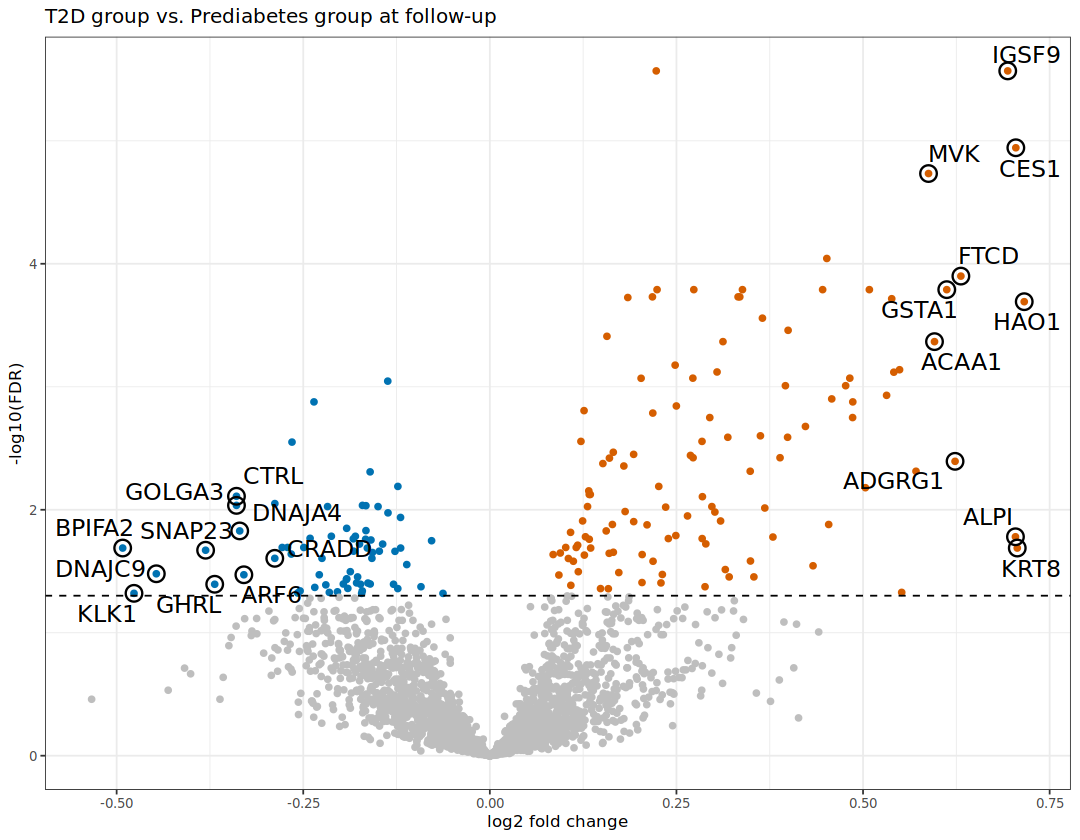

In [35]:
# Select top 10 up/down
tt2_df <- as.data.frame(tt2) 
# Top 10 upregulated
top_up <- tt2 %>%
  filter(adj.P.Val < 0.05, logFC > 0) %>%
  top_n(10, wt = logFC)

# Top 10 downregulated
top_down <- tt2 %>%
  filter(adj.P.Val < 0.05, logFC < 0) %>%
  top_n(-10, wt = logFC)

# Combine
top_proteins <- bind_rows(top_up, top_down)

# # Volcano plot
# ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
#   geom_point(aes(color = case_when(
#     adj.P.Val < 0.05 & logFC > 0 ~ "#D55E00",
#     adj.P.Val < 0.05 & logFC < 0 ~ "#0072B2",
#     TRUE ~ "grey"
#   )), show.legend = FALSE) +
#   geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "black") +
#   xlab("log2 fold change") +
#   ylab("-log10(FDR)") +
#   theme_bw() +
#   scale_color_identity() +
#   theme(text = element_text(size = 21)) +
#   geom_text_repel(
#     data = top_proteins,
#     aes(label = Assay),
#     size = 5,
#     box.padding = 0.4,
#     point.padding = 0.5,
#     max.overlaps = Inf
#   ) +
#   geom_point(
#     data = top_proteins,
#     shape = 21, color = "black", fill = NA, size = 4, stroke = 1
#   )
p2 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = case_when(
    adj.P.Val < 0.05 & logFC > 0 ~ "#D55E00",
    adj.P.Val < 0.05 & logFC < 0 ~ "#0072B2",
    TRUE ~ "grey"
  )), show.legend = FALSE) +
  geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "black") +
  xlab("log2 fold change") +
  ylab("-log10(FDR)") +
  theme_bw() +
  scale_color_identity() +
  theme(text = element_text(size = 21)) +
  geom_text_repel(
    data = top_proteins,
    aes(label = Assay),
    size = 5,
    box.padding = 0.4,
    point.padding = 0.5,
    max.overlaps = Inf
  ) +
  geom_point(
    data = top_proteins,
    shape = 21, color = "black", fill = NA, size = 4, stroke = 1
  ) +
    labs(
        title = "T2D group vs. Prediabetes group at follow-up"
    ) +
    #scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=10))
print(p2)
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/plots/follow-up_T2D_vs_prediabetes.pdf", plot = p2, width = 6, height = 5, units = "in")

In [36]:
#Info on significant proteins
tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)
tt_fdr005_tmp <- tt_fdr005
tt_fdr005_tmp$OlinkID <- rownames(tt_fdr005_tmp)
tmp <- inner_join(tt_fdr005_tmp, assay.ids, by = "OlinkID")
upregulated1 <- subset(tmp, tmp$logFC > 0)
cat("Upregulated proteins:",upregulated1$Assay)
length(upregulated1$Assay)
cat("\n")
cat("\n")
downregulated1 <- subset(tmp, tmp$logFC < 0)
cat("Downregulated proteins:",downregulated1$Assay)
length(downregulated1$Assay)
#background or all proteins
tt$OlinkID <- rownames(tt)
tmp <- inner_join(tt, assay.ids, by = "OlinkID")

Upregulated proteins: PRCP IGSF9 CES1 MVK ACE2 FTCD GSTA1 CDH2 KHK ANGPTL2 MAMDC4 ACY1 CEMIP2 GGT1 SELE CNTN3 SULT2A1 HAO1 PDZK1 FOLH1 NOMO1 ACAA1 ADAMTSL2 PCBD1 ECHS1 RBP5 UPB1 C19orf12 SSC5D CPM AGXT ADH1B GCG GSTA3 ENPP7 CTSD NHLRC3 IGSF3 GUSB KRT18 ADH4 PBLD AKR7L BAIAP2 PLXNB2 IL1RN FURIN PVR LDLR CBS MUC13 LAMB1 ADGRG1 AFM FST SUOX SLC28A1 GFER ECHDC3 NRCAM ASGR1 IGF2R GRPEL1 PAMR1 ALDH2 SCLY CDHR2 THBS2 DCXR CD8A SEMA7A FCAMR KYNU CA5A IL18R1 PRAP1 GHR QSOX1 LBP ITGA5 ALPI GPRC5C PTS NT5E NFASC HAVCR1 ADGRE5 BMPER ITGB2 KRT8 CRELD1 RET CFH PIGR MEGF9 SMPD1 F7 GALNT10 TMPRSS15 RIDA SEL1L LEP CHI3L1 ACP5 PLIN1 MAN2B2 CFI IL6 PYY METAP1D NIT2 ADGRE2 MME LILRA2 ANGPTL4 AKR1B10

[1] 116



Downregulated proteins: APOF CA14 STX7 ABL1 CRYBB1 CTRL IGFBP2 GOLGA3 MIA DNMBP STAT2 MXRA8 VPS53 DTX3 LMOD1 SNX9 DNAJA4 AMY1A_AMY1B_AMY1C KITLG USP25 LMOD1 CLEC4A CYB5R2 NEO1 CDNF SLMAP DCTN1 ELAC1 COL9A1 GIMAP7 BPIFA2 PTPRN2 SNAP23 STX4 RHOC PPM1F PTPRR TBCB CRADD GMFG VGF ACAN MAP2K1 DNAJC9 SARG ARF6 LUZP2 JPT2 AMY2A EBAG9 LMOD1 HSBP1 NEDD4L GHRL CALCB KIAA0319 CASP8 PTPRS CKB TPD52L2 PPP1R2 ERBIN CRIP2 STAMBP CNP BCL2L1 KLK1 GSN RABEP1

[1] 69

### Over-representation analysis on proteins which are significantly differentially expressed and have a shared pQTL between T2D and prediabetes

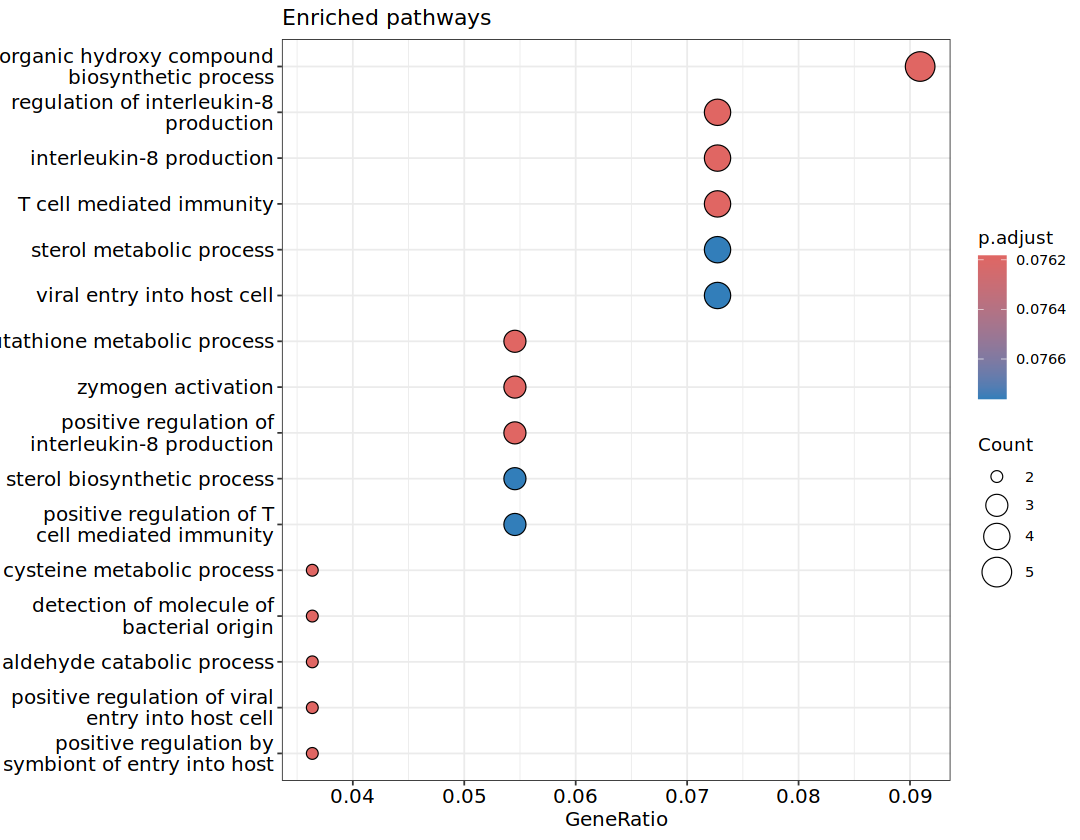

In [55]:
#Checking what shared pQTL signals and the corresponding protein overlap with differentially expressed proteins
shared_signals <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/shared_sig_signals_OIDs_prediabetes_diabetes.txt")
up_t2d_tmp <- inner_join(shared_signals, upregulated1, by = c("signal" = "OlinkID"))
fwrite(up_t2d_tmp, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/up_proteins_shared_pQTLs.txt")
down_t2d_tmp <- inner_join(shared_signals, downregulated1, by = c("signal" = "OlinkID"))
fwrite(down_t2d_tmp, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/down_proteins_shared_pQTLs.txt")
df_tmp <- inner_join(shared_signals, tt_fdr005_tmp, by = c("signal" = "OlinkID"))
df_tmp <- inner_join(df_tmp, assay.ids, by = c("signal" = "OlinkID"))
#pathway enrichment analysis
# Convert gene symbols to Entrez IDs
# gene.df <- bitr(df_tmp$Assay, fromType = "SYMBOL",
#                 toType = "ENTREZID",
#                 OrgDb = org.Hs.eg.db)
# background_entrez <- bitr(tt2$Assay, fromType = "SYMBOL",
#                           toType = "ENTREZID",
#                           OrgDb = org.Hs.eg.db)
#Backgound used here is the complete set of annotated genes in GO
ego <- enrichGO(gene         = df_tmp$Assay,
                OrgDb        = org.Hs.eg.db,
                keyType      = "SYMBOL",
                ont          = "BP",       # Biological Process
                pAdjustMethod= "BH",
                pvalueCutoff = 0.08,
                qvalueCutoff = 0.08)
dotplot(ego, showCategory = 20, title = "Enriched pathways")

#dotplot(gse, showCategory = 10, title = "Enriched pathways" , split=".sign") + facet_grid(.~.sign)
p4 <- dotplot(ego, showCategory = 20, title = "Enriched pathways")
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/GSEA_GO_enriched_pathways_shared_pQTLs_corresponding_DEPs.pdf", plot = p4, width = 10, height = 6)

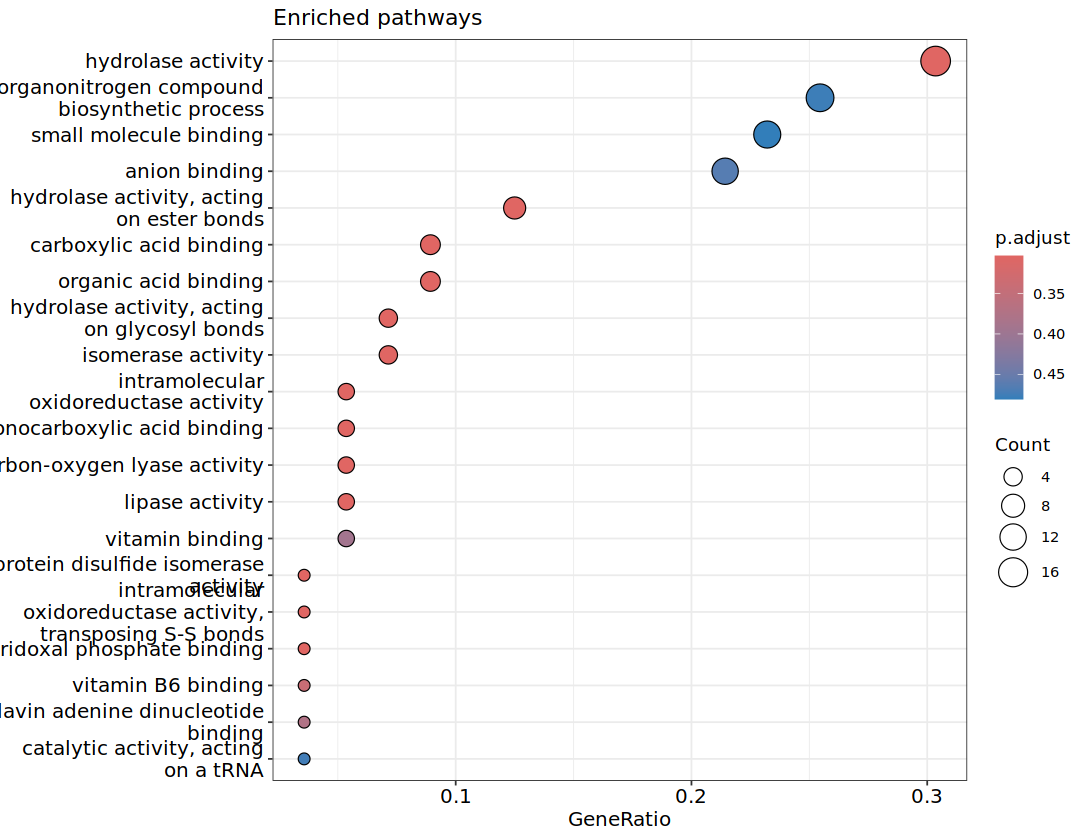

In [53]:
ego <- enrichGO(
  gene          = df_tmp$Assay,      # foreground genes
  OrgDb         = org.Hs.eg.db,
  keyType       = "SYMBOL",
  ont           = "ALL",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.5,
  qvalueCutoff  = 0.5,
  universe      = tt2$Assay          # background gene list
)
dotplot(ego, showCategory = 20, title = "Enriched pathways")


In [113]:
tmp[tmp$Assay == "SELE",]
tmp[tmp$Assay == "SCLY",]
tmp[tmp$Assay == "ACP5",]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,OlinkID,UniProt,Assay
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
15,0.3325892,-0.08256748,4.949112,1.104772e-06,0.0001858226,5.218127,OID20290,P16581,SELE


,logFC,AveExpr,t,P.Value,adj.P.Val,B,OlinkID,UniProt,Assay
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
78,0.2355783,-0.06070929,3.65269,0.0002943789,0.009522027,0.1102205,OID21425,Q96I15,SCLY


,logFC,AveExpr,t,P.Value,adj.P.Val,B,OlinkID,UniProt,Assay
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
147,0.1185249,0.007522249,3.133006,0.001858938,0.03190545,-1.535261,OID20314,P13686,ACP5


In [101]:
write.table(upregulated1$Assay, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/up_T2_diabetic_vs_prediabetic.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(downregulated1$Assay, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/down_T2_diabetic_vs_prediabetic.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(tmp$Assay, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/all_or_background_T2_diabetic_vs_prediabetic.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
fwrite(tmp, file = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/all_significant_T2_diabetic_vs_prediabetic.txt", col.names = T)

### Gene set enrichment analysis

In [102]:
# Get the genes that are present in your dataframe
#tt_fdr005_tmp$OlinkID <- rownames(tt_fdr005_tmp)
df <- inner_join(tt, assay.ids, by = "OlinkID")
# we want the log2 fold change 
original_gene_list <- df$logFC
names(original_gene_list) <- df$Assay
# omit any NA values 
gene_list <- na.omit(original_gene_list)
# sort the list in decreasing order (required for clusterProfiler)
gene_list = sort(gene_list, decreasing = TRUE)

In [103]:
gse <- gseGO(geneList=gene_list, 
             ont ="ALL", 
             keyType = "SYMBOL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = org.Hs.eg.db, 
             pAdjustMethod = "none")

preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
leading edge analysis...

done...



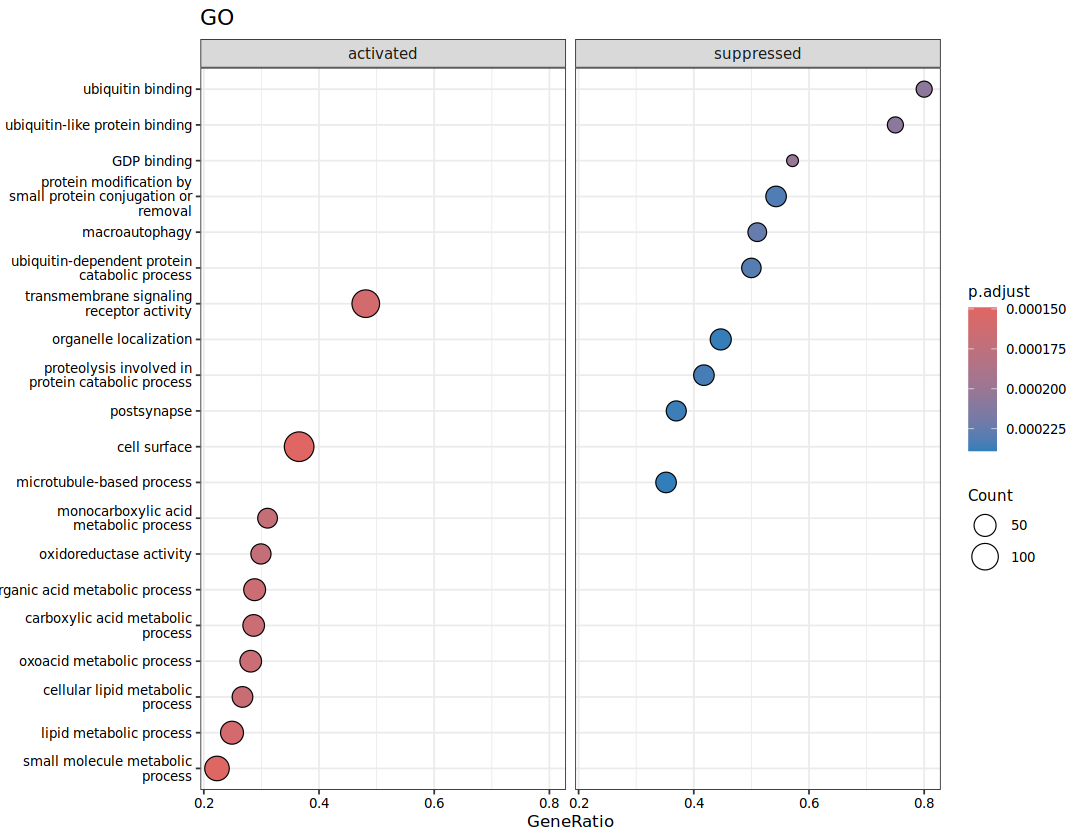

In [104]:
dotplot(gse, showCategory = 10, title = "GO", split = ".sign") + 
  facet_grid(. ~ .sign) +
  theme(
    axis.text.y = element_text(size = 8),   # category labels
    axis.text.x = element_text(size = 8),   # x-axis numbers
    axis.title  = element_text(size = 10),  # axis titles
    strip.text  = element_text(size = 9),   # facet labels (.sign)
    legend.text = element_text(size = 8),   # legend labels
    legend.title= element_text(size = 9)    # legend title
  )
p3 <- dotplot(gse, showCategory = 10, title = "GO", split = ".sign") + 
  facet_grid(. ~ .sign) +
  theme(
    axis.text.y = element_text(size = 8),   # category labels
    axis.text.x = element_text(size = 8),   # x-axis numbers
    axis.title  = element_text(size = 10),  # axis titles
    strip.text  = element_text(size = 9),   # facet labels (.sign)
    legend.text = element_text(size = 8),   # legend labels
    legend.title= element_text(size = 9)    # legend title
  )
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/plots/GSEA_GO_T2D_vs_prediabetes_pathways.pdf", plot = p3, width = 10, height = 6)

In [105]:
# Convert gene IDs for gseKEGG function
# We will lose some genes here because not all IDs will be converted
ids1<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENSEMBL", OrgDb=org.Hs.eg.db)
ids<-bitr(ids1$ENSEMBL, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb=org.Hs.eg.db)
ids <- inner_join(ids, ids1, by = "ENSEMBL")
 # remove duplicate IDS (here I use "ENSEMBL", but it should be whatever was selected as keyType)
dedup_ids = ids[!duplicated(ids[c("ENSEMBL")]),]

# Create a new dataframe df2 which has only the genes which were successfully mapped using the bitr function above
df2 = df[df$Assay %in% ids1$SYMBOL,]
df2 <- inner_join(df2, dedup_ids, by = c("Assay" = "SYMBOL"))

# Create a vector of the gene unuiverse
kegg_gene_list <- df2$logFC

# Name vector with ENTREZ ids
names(kegg_gene_list) <- df2$ENTREZID

# omit any NA values 
kegg_gene_list<-na.omit(kegg_gene_list)

# sort the list in decreasing order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)
kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENSEMBL", :
“1% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in inner_join(df2, dedup_ids, by = c(Assay = "SYMBOL")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 3 of `x` matches multiple rows in `y`.
ℹ Row 98 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. T

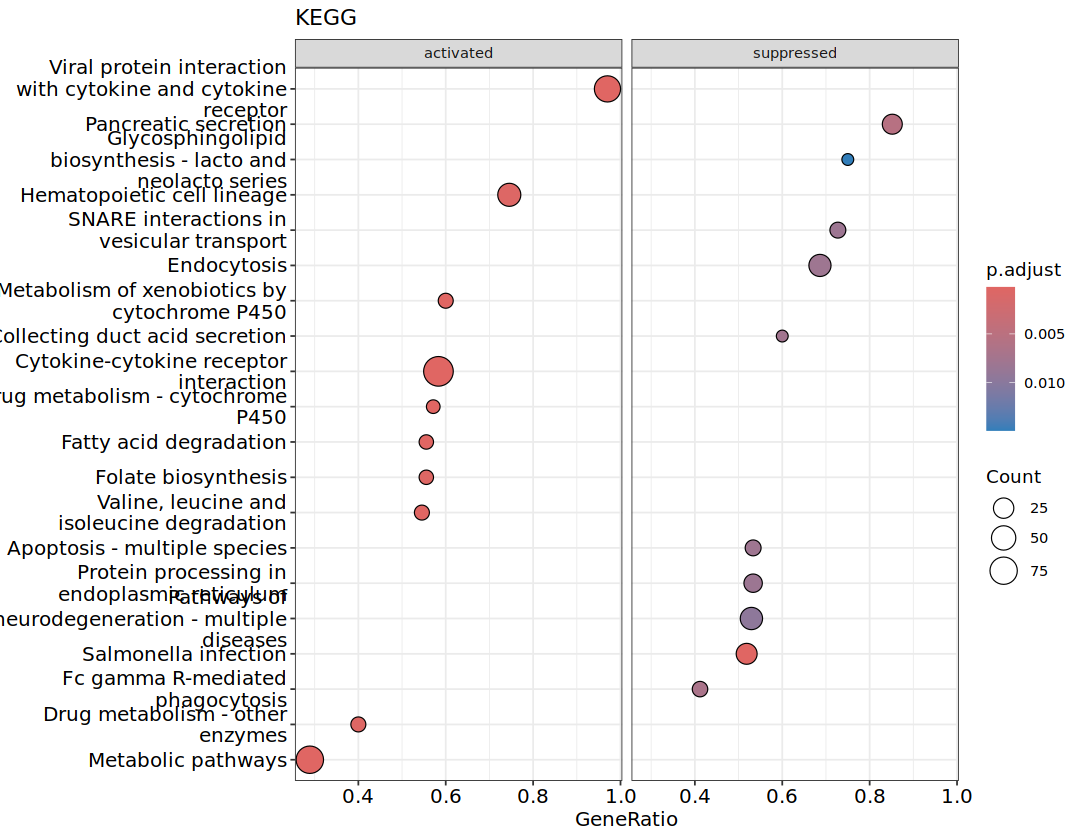

In [108]:
dotplot(kk2, showCategory = 10, title = "KEGG" , split=".sign") + facet_grid(.~.sign)
p4 <- dotplot(kk2, showCategory = 10, title = "KEGG" , split=".sign") + facet_grid(.~.sign) +
  theme(
    axis.text.y = element_text(size = 8),   # category labels
    axis.text.x = element_text(size = 8),   # x-axis numbers
    axis.title  = element_text(size = 10),  # axis titles
    strip.text  = element_text(size = 9),   # facet labels (.sign)
    legend.text = element_text(size = 8),   # legend labels
    legend.title= element_text(size = 9))    # legend title
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T2_only/plots/GSEA_KEGG_T2D_vs_prediabetes_pathways.pdf", plot = p4, width = 10, height = 6)